<a href="https://colab.research.google.com/github/rs-delve/tti-explorer/blob/master/notebooks/tti-experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TTI Strategies

All of the information about the primary case's infection and how they infect their social contacts (under no government intervention) is now contained in `primary_case` and `social_contacts`.

Now we run a simulation, which works as follows. We start by generating a large number of cases, each with associated contacts. Given a particular strategy (e.g. test-based TTI with NPI of stringency level S3), each case is passed through the strategy, which computes various metrics for the case. For example, it computes the number of secondary cases due to primary case (reproduction number) and the number of tests required. We then collect the results for each case and average them, returning the final evaluation of the strategy.

## Running a Simulation

In [1]:
!git clone https://github.com/rs-delve/tti-explorer.git
%cd tti-explorer
%pip install -q .

import os

import numpy as np
import pandas as pd
from tqdm.notebook import trange

from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

%pip install pyDOE
%pip install emukit
%pip install gpy
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/teaching_plots.py','teaching_plots.py')
urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/mlai.py','mlai.py')
urllib.request.urlretrieve('https://raw.githubusercontent.com/lawrennd/talks/gh-pages/gp_tutorial.py','gp_tutorial.py')


from matplotlib import colors as mcolors
from matplotlib import cm
import numpy as np
import GPy
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity
from emukit.core.initial_designs import RandomDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
import matplotlib.pyplot as pltb
import teaching_plots as plot
import mlai
import pandas as pd

fatal: destination path 'tti-explorer' already exists and is not an empty directory.
/Users/milliemcquillin/Desktop/MPhil/ML & PW/project/tti-le48/tti-explorer-with-changes/notebooks/tti-explorer
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


We will analyse the `S3_test_based_TTI` strategy from our report. For clarity, we will show the whole process.

In [2]:
def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")

path_to_bbc_data = os.path.join("data", "bbc-pandemic")

over18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_o18.csv"))
under18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_u18.csv"))

First get the configurations:

In [3]:
name = 'S3_test_based_TTI'

case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
policy_config = config.get_strategy_configs("delve", name)[name]

In [4]:
from scipy.stats import gamma

def update_case_config_day_noticed(p_day_noticed_symptoms_ab):
    alpha = p_day_noticed_symptoms_ab[0]
    beta = p_day_noticed_symptoms_ab[1]

    x = np.linspace(gamma.pdf(0.01, a=alpha, scale=1/beta),
                    gamma.pdf(0.99, a=alpha, scale=1/beta), 10)
    
    #apply softmax
    norm = np.exp(x)
    s = sum(norm)
    norm = np.round(norm/s, decimals=2)
    norm[-1] = 1- sum(norm[:-1])
    
    case_config['p_day_noticed_symptoms'] = norm
    
    return case_config



def update_case_config_daily(vals):
    
    case_config['inf_profile'] = vals
    
    return case_config




def update_case_inf_profile(inf_profile):
    alpha = inf_profile[0]
    beta = inf_profile[1]

    x = np.linspace(gamma.pdf(0.01, a=alpha, scale=1/beta),
                    gamma.pdf(0.99, a=alpha, scale=1/beta), 10)
    
    #apply softmax
    norm = np.exp(x)
    s = sum(norm)
    norm = np.round(norm/s, decimals=2)
    norm[-1] = 1- sum(norm[:-1])
    
    case_config['p_day_noticed_symptoms'] = norm
    
    return case_config

# update_case_config([1,3])

In [5]:
def update_policy_config(app_uptake, pol_compl):
    policy_config['app_cov'] = app_uptake
    policy_config['compliance'] = pol_compl
    return policy_config

# policy_config = update_policy_config(0.5, 0.05)

In [6]:
# Separating this because it is built from the ammended policy_config

factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)

Set a random state:

In [7]:
rng = np.random.RandomState(42)

Make contact simulator:

In [8]:
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)

Make the TTI Model:

In [9]:
tti_model = TTIFlowModel(rng, **strategy_config)

Generate cases, contacts and run simulation:

In [10]:
"""
Runs TTI simulator as many times as the different input initialisations.
The main reason we need this is to put in to EmuKit for the Experimental
Design Loop.

Args:
    pol_configs (list): Inputs are [app_cov, compliance]

Returns:
    effective_rs (np.expand_dims(np.array(to_return), 1)): For every simulation run, return
    the effective r, as was plotted form Bryn and Andrei previously.

"""
rng = np.random.RandomState(42)
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)

def run_tti_sim(pol_configs):
    
    to_return=[]

    for vals in pol_configs:

        case_config = update_case_config_daily(vals)
        #policy_config = update_policy_config(vals[0],vals[1])
        factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
        strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
        tti_model = TTIFlowModel(rng, **strategy_config)
        
        n_cases = 10000
        outputs = list()
        temp =[]
        
        for _ in trange(n_cases):
            case = simulate_case(rng, **case_config)
            
            case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
            contacts = simulate_contacts(case, **contacts_config)
            res = tti_model(case, contacts, case_factors)
            outputs.append(res)
            
            if res["Effective R"] >= 0:
                temp.append(res["Effective R"]) # Get effective R. Only non-nan vals are kept
                
        to_return.append(np.mean(temp))
        
    return np.expand_dims(np.array(to_return), 1)




In [11]:
variable_domain = [0.05, 1] 
variable_domain2 = [0.01,1]

# space = ParameterSpace([ContinuousParameter('alpha', *variable_domain2),
#                         ContinuousParameter('beta', *variable_domain2)]) # init param space for experimental design

space = ParameterSpace([ContinuousParameter('Day_1', *variable_domain2),
                        ContinuousParameter('Day_2', *variable_domain2),
                        ContinuousParameter('Day_3', *variable_domain2),
                        ContinuousParameter('Day_4', *variable_domain2),
                        ContinuousParameter('Day_5', *variable_domain2),
                        ContinuousParameter('Day_6', *variable_domain2),
                        ContinuousParameter('Day_7', *variable_domain2),
                        ContinuousParameter('Day_8', *variable_domain2),
                        ContinuousParameter('Day_9', *variable_domain2),
                        ContinuousParameter('Day_10', *variable_domain2)]) 

In [12]:
# Set variables range. Since we are dealing with percentages (app_cov, compliance)
# [0.05, 1] should do.
initial_samples = 20 # number of random runs to perform before starting experimental design 

design = RandomDesign(space)

x = design.get_samples(initial_samples) # get 5 random combinations of initialisations

for i, values in enumerate(x):
    x[i] = list(values/values.sum())

y = run_tti_sim(x) # obtain corresponding effective_rs

In [15]:
# Fitting emulator to data, x: (app_cov, compliance), y: effective_r
Num_of_param = 10
kern_eq = GPy.kern.RBF(input_dim=Num_of_param, ARD = True)
kern_bias = GPy.kern.Bias(input_dim=Num_of_param)
kern = kern_eq + kern_bias
model_gpy = GPRegression(x,y, kern)
model_gpy.kern.variance = 1**2
model_gpy.likelihood.variance.fix(1e-5)
model_emukit = GPyModelWrapper(model_gpy) 
model_emukit.optimize() # optimise (max log-lik)
display(model_gpy)



Optimization restart 1/1, f = -23.416883067569294


GP_regression.,value,constraints,priors
sum.rbf.variance,0.008179146391740302,+ve,
sum.rbf.lengthscale,"(10,)",+ve,
sum.bias.variance,1.7552579309700849,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [16]:
# Initialise experimental design loop. Using integrated variance as acquisition
# to "query" the input space aiming to reduce uncertainty over the func we're approx. i.e. effective_r
num_of_loops = 10
integrated_variance = IntegratedVarianceReduction(space=space, model=model_emukit)
ed = ExperimentalDesignLoop(space=space, model=model_emukit, acquisition = integrated_variance)
ed.run_loop(run_tti_sim, 2)

Optimization restart 1/1, f = -23.416883084062505



Optimization restart 1/1, f = -5.056382960254403



Optimization restart 1/1, f = -3.0917790778574368


main_effects:  {'Day_1': array([0.21135858]), 'Day_2': array([0.02368884]), 'Day_3': array([0.27250077]), 'Day_4': array([0.21291987]), 'Day_5': array([0.0751183]), 'Day_6': array([0.02368882]), 'Day_7': array([0.02368816]), 'Day_8': array([0.02368885]), 'Day_9': array([0.02368871]), 'Day_10': array([0.11641305])}
total_effects:  {'Day_1': array([0.29325861]), 'Day_2': array([-0.02697592]), 'Day_3': array([0.3922079]), 'Day_4': array([0.2456045]), 'Day_5': array([0.12186709]), 'Day_6': array([-0.0269759]), 'Day_7': array([-0.02697575]), 'Day_8': array([-0.02697593]), 'Day_9': array([-0.02697594]), 'Day_10': array([0.02589222])}


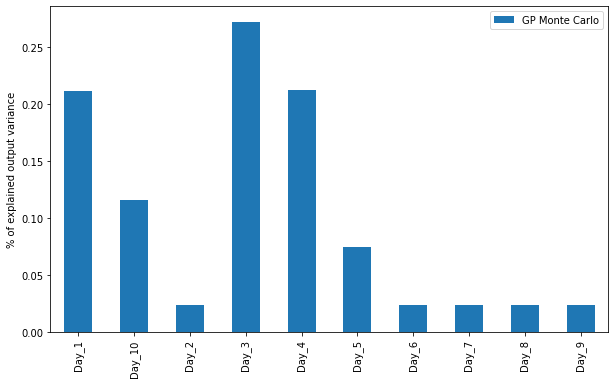

In [17]:
# Plot Main Effects

num_mc = 10000
senstivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)
print("main_effects: ", main_effects_gp)
print("total_effects: ", total_effects_gp)


fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':main_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')

mlai.write_figure(filename='first-order-sobol-indices-gp-catapult.svg', directory='./uq')

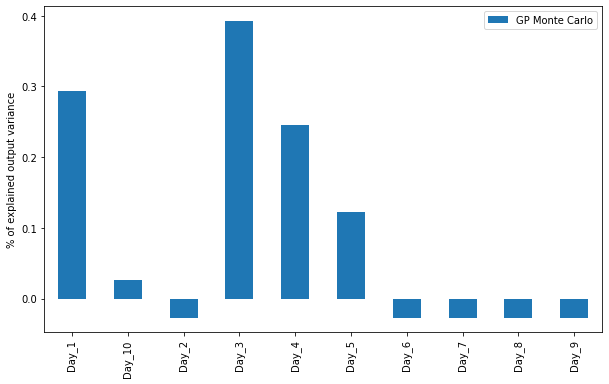

In [18]:
# Plot Total Effects

fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}

d = {'GP Monte Carlo':total_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
ax.set_ylabel('% of explained output variance')

mlai.write_figure(filename='total-effects-sobol-indices-gp-catapult.svg', directory='./uq')